0000000326


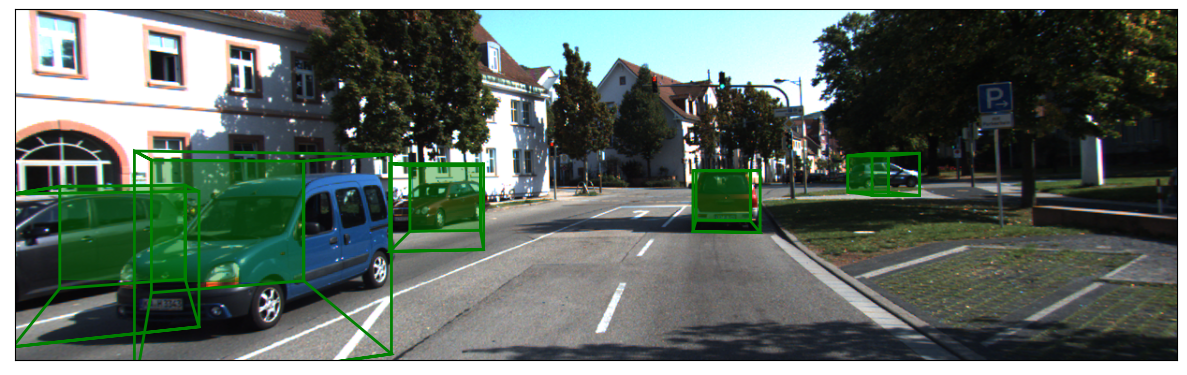

In [38]:
#https://github.com/whatdhack/computer_vision/tree/master/kitti_3dobj_det_chk 
#3D bounding box visualization using geometric and trignometric calculations
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.gridspec import GridSpec
from PIL import Image
import easydict
from utils.read_dir import ReadDir
from config import config as cfg
from utils.correspondece_constraint import *

def compute_3Dbox(P2, line):
    obj = detectionInfo(line)
    # Draw 2D Bounding Box
    xmin = int(obj.xmin)
    xmax = int(obj.xmax)
    ymin = int(obj.ymin)
    ymax = int(obj.ymax)
    
    R = np.array([[np.cos(obj.rot_global), 0, np.sin(obj.rot_global)],
                  [0, 1, 0],
                  [-np.sin(obj.rot_global), 0, np.cos(obj.rot_global)]])

    x_corners = [0, obj.l, obj.l, obj.l, obj.l, 0, 0, 0]  # -l/2
    y_corners = [0, 0, obj.h, obj.h, 0, 0, obj.h, obj.h]  # -h
    z_corners = [0, 0, 0, obj.w, obj.w, obj.w, obj.w, 0]  # -w/2

    x_corners = [i - obj.l / 2 for i in x_corners]
    y_corners = [i - obj.h for i in y_corners]
    z_corners = [i - obj.w / 2 for i in z_corners]

    corners_3D = np.array([x_corners, y_corners, z_corners])
    corners_3D = R.dot(corners_3D)
    corners_3D += np.array([obj.tx, obj.ty, obj.tz]).reshape((3, 1))

    corners_3D_1 = np.vstack((corners_3D, np.ones((corners_3D.shape[-1]))))
    corners_2D = P2.dot(corners_3D_1)
    corners_2D = corners_2D / corners_2D[2]
    corners_2D = corners_2D[:2]

    return corners_2D

def draw_3Dbox(ax, P2, line, color):

    corners_2D = compute_3Dbox(P2, line)

    # draw all lines through path
    bb3d_lines_verts_idx = [0, 1, 2, 3, 4, 5, 6, 7, 0, 5, 4, 1, 2, 7, 6, 3]
    bb3d_on_2d_lines_verts = corners_2D[:, bb3d_lines_verts_idx]
    verts = bb3d_on_2d_lines_verts.T
    codes = [Path.LINETO] * verts.shape[0]
    codes[0] = Path.MOVETO
    # codes[-1] = Path.CLOSEPOLYq
    pth = Path(verts, codes)
    p = patches.PathPatch(pth, fill=False, color=color, linewidth=2)

    width = corners_2D[:, 3][0] - corners_2D[:, 1][0]
    height = corners_2D[:, 2][1] - corners_2D[:, 1][1]
    # put a mask on the front
    front_fill = patches.Rectangle((corners_2D[:, 1]), width, height, fill=True, color=color, alpha=0.4)
    ax.add_patch(p)
    ax.add_patch(front_fill)

def visualization(args, image_path, label_path, calib_path, pred_path,
                  dataset, VEHICLES):

    for index in range(start_frame, end_frame):
        image_file = os.path.join(image_path, dataset[index]+ '.png')
        label_file = os.path.join(label_path, dataset[index] + '.txt')
        prediction_file = os.path.join(pred_path, dataset[index]+ '.txt')
        calibration_file = os.path.join(calib_path, dataset[index] + '.txt')
        for line in open(calibration_file):
            if 'P2' in line:
                P2 = line.split(' ')
                P2 = np.asarray([float(i) for i in P2[1:]])
                P2 = np.reshape(P2, (3, 4))


        fig = plt.figure(figsize=(20.00, 5.12), dpi=100)

        # fig.tight_layout()
        gs = GridSpec(1, 4)
        gs.update(wspace=0)  # set the spacing between axes.

        ax = fig.add_subplot(gs[0, :3])

        image = Image.open(image_file).convert('RGB')
        shape = 900

        with open(label_file) as f1, open(prediction_file) as f2:
            for line_gt, line_p in zip(f1, f2):
                line_gt = line_gt.strip().split(' ')
                line_p = line_p.strip().split(' ')
                color = 'green'
                draw_3Dbox(ax, P2, line_p, color)

        # visualize 3D bounding box
        ax.imshow(image)
        ax.set_xticks([]) #remove axis value
        ax.set_yticks([])

        # plot camera view range
        x1 = np.linspace(0, shape / 2)
        x2 = np.linspace(shape / 2, shape)
        print(dataset[index])
        if args.save == False:
            plt.show()
        else:
            fig.savefig(os.path.join(args.path, dataset[index]), dpi=fig.dpi, bbox_inches='tight', pad_inches=0)
        

def main(args):
    base_dir = 'C:\sabeeha\KITTI\KITTI_O'
    label_path = "C:\sabeeha\KITTI\KITTI_O\label_2"
    image_path = "C:\sabeeha\KITTI\KITTI_O\image_2"
    calib_path = "C:\sabeeha\KITTI\KITTI_O\calib"
    pred_path = "C:\sabeeha\KITTI\KITTI_O\output"

    dataset = [name.split('.')[0] for name in sorted(os.listdir(image_path))]

    visualization(args, image_path, label_path, calib_path, pred_path,dataset, "Car")

if __name__ == '__main__':
    start_frame = 0
    end_frame = 1
    args = easydict.EasyDict({
         "dataset": 'tracklet',
         "save":True,
         "path": 'C:\\sabeeha\\KITTI\\KITTI_O\\output_images'
    })

    if not os.path.exists(args.path):
        os.mkdir(args.path)

    main(args)
